# Bean Classification Project Proposal 

In [3]:
#run this cell before continuing
install.packages("themis")
library(tidyverse)
library(repr)
library(tidymodels)
options(repr.matrix.max.rows = 16)
library(readxl)

also installing the dependencies ‘RANN’, ‘ROSE’


Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   

In [4]:
library(themis)

# Introduction

This dataset is based on 13611 images of 7 types of individual dry beans with similar features. Each image was analyzed for 16 features of the bean (4 "shape factors", 12 structural/geometric features) (Kolku & Ozkan, 2020).


The question we will be answering is whether we can determine the bean type in an image based on their dimensional features. The most effective dimensional features in the dataset, are called: "Area", "Perimeter", "Major Axis Length", "Minor Axis Length", "Aspect Ratio", "Eccentricity", "Convex Area", "Equivalent Diameter", "Extent", "Solidity", "Roundness", "Compactness". We will be using K-nearest neighbors classification to predict "Class" using the mentioned predictors.

Our variable of intetrest (Kolku & Ozkan, 2020).:
- **Area**:The area of a bean zone and the number of pixels within its boundaries.
- **Perimeter**: Bean circumference is defined as the length of its border.
- **Major Axis Length**: The distance of the longest line that can be drawn on the bean
- **Minor Axis Length**: The longest line that can be drawn on the bean while standing perpendicular to the axis
- **Aspect Ratio**: The relationship between the Major Axis Length and the Minor Axis Length
- **Eccentricity**: Eccentricity of the ellipse having the same moments as the region.
- **Convex Area**: Number of pixels in the smallest convex polygon that can contain the area of a bean seed.
- **Equivalent Diameter**: The diameter of a circle that has the same area as the bean area
- **Solidity**: The ratio of the pixels in the convex shell to those found in beans.
- **Extent**: The ratio of the pixels in the bounding box to the bean area.
- **Roundess**: Calculated with the following formula: (4piA)/(P^2). Where A is the area and P is the perimeter of the bean
- **Compactness**: Roundness of the bean in measurement

# Preliminary exploratory data analysis

In [5]:
beanurl<-"https://archive.ics.uci.edu/ml/machine-learning-databases/00602/DryBeanDataset.zip"
temp <- tempfile()
download.file(beanurl,temp)
beanzip <- unzip(temp, "DryBeanDataset/Dry_Bean_Dataset.xlsx")
bean <- read_excel(beanzip)
bean

Area,Perimeter,MajorAxisLength,MinorAxisLength,AspectRation,Eccentricity,ConvexArea,EquivDiameter,Extent,Solidity,roundness,Compactness,ShapeFactor1,ShapeFactor2,ShapeFactor3,ShapeFactor4,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
28395,610.291,208.1781,173.8887,1.197191,0.5498122,28715,190.1411,0.7639225,0.9888560,0.9580271,0.9133578,0.007331506,0.003147289,0.8342224,0.9987239,SEKER
28734,638.018,200.5248,182.7344,1.097356,0.4117853,29172,191.2728,0.7839681,0.9849856,0.8870336,0.9538608,0.006978659,0.003563624,0.9098505,0.9984303,SEKER
29380,624.110,212.8261,175.9311,1.209713,0.5627273,29690,193.4109,0.7781132,0.9895588,0.9478495,0.9087742,0.007243912,0.003047733,0.8258706,0.9990661,SEKER
30008,645.884,210.5580,182.5165,1.153638,0.4986160,30724,195.4671,0.7826813,0.9766957,0.9039364,0.9283288,0.007016729,0.003214562,0.8617944,0.9941988,SEKER
30140,620.134,201.8479,190.2793,1.060798,0.3336797,30417,195.8965,0.7730980,0.9908933,0.9848771,0.9705155,0.006697010,0.003664972,0.9419004,0.9991661,SEKER
30279,634.927,212.5606,181.5102,1.171067,0.5204007,30600,196.3477,0.7756885,0.9895098,0.9438518,0.9237260,0.007020065,0.003152779,0.8532696,0.9992358,SEKER
30477,670.033,211.0502,184.0391,1.146768,0.4894779,30970,196.9886,0.7624015,0.9840814,0.8530799,0.9333736,0.006924899,0.003242016,0.8711862,0.9990487,SEKER
30519,629.727,212.9968,182.7372,1.165591,0.5137596,30847,197.1243,0.7706818,0.9893669,0.9671092,0.9254804,0.006979152,0.003158285,0.8565140,0.9983446,SEKER
⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮,⋮


Select the variables that we want to keep for building a classification predictor

TODO: Filter out Barbunya class due to the lack of clustering in the dataset

In [6]:
select_bean <- bean |>
                select("Area","roundness","Class")|>
                filter(Class != "BARBUNYA")|>
                mutate(Class = as.factor(Class))
select_bean

Area,roundness,Class
<dbl>,<dbl>,<fct>
28395,0.9580271,SEKER
28734,0.8870336,SEKER
29380,0.9478495,SEKER
30008,0.9039364,SEKER
30140,0.9848771,SEKER
30279,0.9438518,SEKER
30477,0.8530799,SEKER
30519,0.9671092,SEKER
⋮,⋮,⋮


Splitting the dataset into training and testing

In [7]:
##Creating training and testing dataset

set.seed(2022)
bean_split <- initial_split(select_bean, prop = 0.75, strata = Class)
bean_train <- training(bean_split)
bean_test <- testing(bean_split)

Graphing the training dataset in plot point

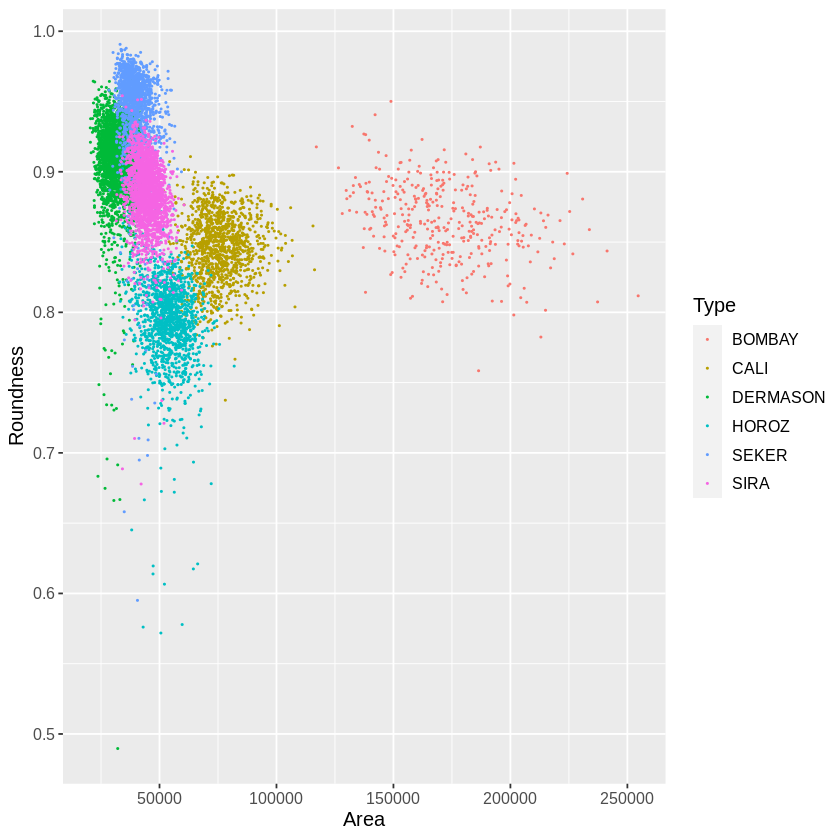

In [8]:
#Graphing the training dataset

area_round_plot <- bean_train |>
  ggplot(aes(x = Area, y = roundness, color = Class)) +
  geom_point(size = 0.2) +
  labs(x = "Area", 
       y = "Roundness",
       color = "Type") +
  theme(text = element_text(size = 12))
area_round_plot

From the point plot of the area vs roundness observation above, we can see that there are big difference between area value and the roundness value, therefore, we will scale the data, which will be dealt with in `workflow()` 

In [9]:
#Summarize training dataset
bean_class_dist <- bean_train |>
                group_by(Class)|>
                summarize(count = n()) |>
                mutate(percentage_dist = 100*count/nrow(bean_train))
bean_class_dist

Class,count,percentage_dist
<fct>,<int>,<dbl>
BOMBAY,380,4.123711
CALI,1222,13.260988
DERMASON,2667,28.941942
HOROZ,1447,15.702659
SEKER,1524,16.538253
SIRA,1975,21.432447


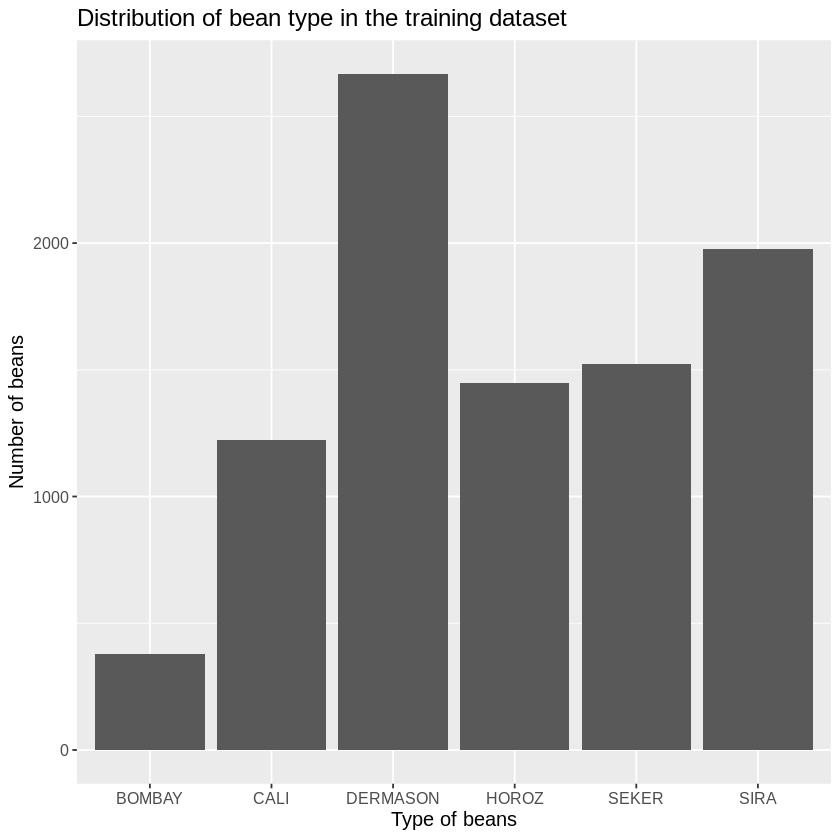

In [10]:
bean_class_dist_plot <- bean_class_dist |>
                        ggplot(aes(x=Class, y = count))+
                        geom_bar(stat = "identity")+
                        labs(x= "Type of beans",
                             y = "Number of beans")+
                        ggtitle("Distribution of bean type in the training dataset")+
                        theme(text = element_text(size = 12))
bean_class_dist_plot

By looking at the table viewing the total number of datapoints for each type of beans, we can see that there are a big difference in number of datapoints between Dermason bean type with other type of beans. Therefore, we will upsample the training dataset so that each Class of bean has a voting power when it comes to the classfication of the testing dataset

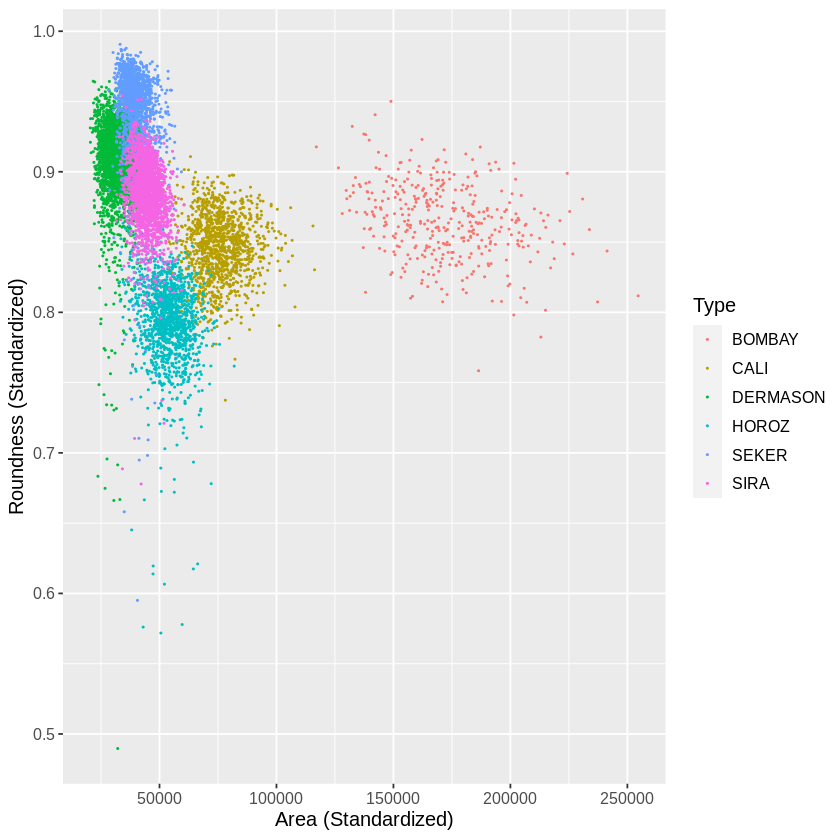

In [11]:
## Scalling all data:
set.seed(2022)
bean_data_training_scaled_recipe <- recipe(Class ~., data = bean_train) |>
                        step_upsample(Class)|>
                        prep()
final_bean_data <- bake(bean_data_training_scaled_recipe, bean_train)

area_round_plot_scaled <- final_bean_data |>
  ggplot(aes(x = Area, y = roundness, color = Class)) +
  geom_point(size = 0.2) +
  labs(x = "Area (Standardized)", 
       y = "Roundness (Standardized)",
       color = "Type") +
  theme(text = element_text(size = 12))
area_round_plot_scaled

The table, and bar chart below show us the distribution of bean types in the training set

Next we will look at Statistical distribution of our chosen variables, in table and boxplot form

In [12]:
#Statistical Distribution of predictor based on class
features_dist_by_class <- final_bean_data |>
                group_by(Class)|>
                summarize(max_area = max(Area, na.rm = TRUE),
                          min_area = min(Area, na.rm = TRUE),
                          std_dev_area = sd(Area, na.rm = TRUE),
                          max_roundness = max(roundness, na.rm = TRUE),
                          min_roundness = min(roundness, na.rm = TRUE),
                         std_dev_roundness = sd(roundness, na.rm = TRUE))
features_dist_by_class

Class,max_area,min_area,std_dev_area,max_roundness,min_roundness,std_dev_roundness
<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BOMBAY,254616,117034,22827.238,0.9501045,0.7584168,0.02733660
CALI,116272,45504,9417.061,0.9107939,0.7374636,0.02318165
DERMASON,42159,20420,4670.699,0.9666028,0.4896183,0.02917184
HOROZ,81929,33006,7381.962,0.9190136,0.5718009,0.03143601
SEKER,59385,28395,4814.962,0.9906854,0.5950484,0.03290233
SIRA,60493,31519,4543.983,0.9541042,0.6778369,0.02382635


In [13]:
#Statistical Distribution in Features of varieties of dry bean
features_dist <- bean_train |>
            select(Area,roundness) |>
            pivot_longer(cols= Area:roundness,
                         names_to = "Features",
                         values_to = "values") |>
            group_by(Features) |>
            summarize(Mean = mean(values, na.rm = TRUE),
                      Min = min(values, na.rm = TRUE),
                      Max = max(values, na.rm = TRUE),
                     Std_Deviation = sd(values, na.rm = TRUE))
features_dist

Features,Mean,Min,Max,Std_Deviation
<chr>,<dbl>,<dbl>,<dbl>,<dbl>
Area,5.108452e+04,2.042000e+04,2.546160e+05,2.964613e+04
roundness,8.813456e-01,4.896183e-01,9.906854e-01,5.496258e-02


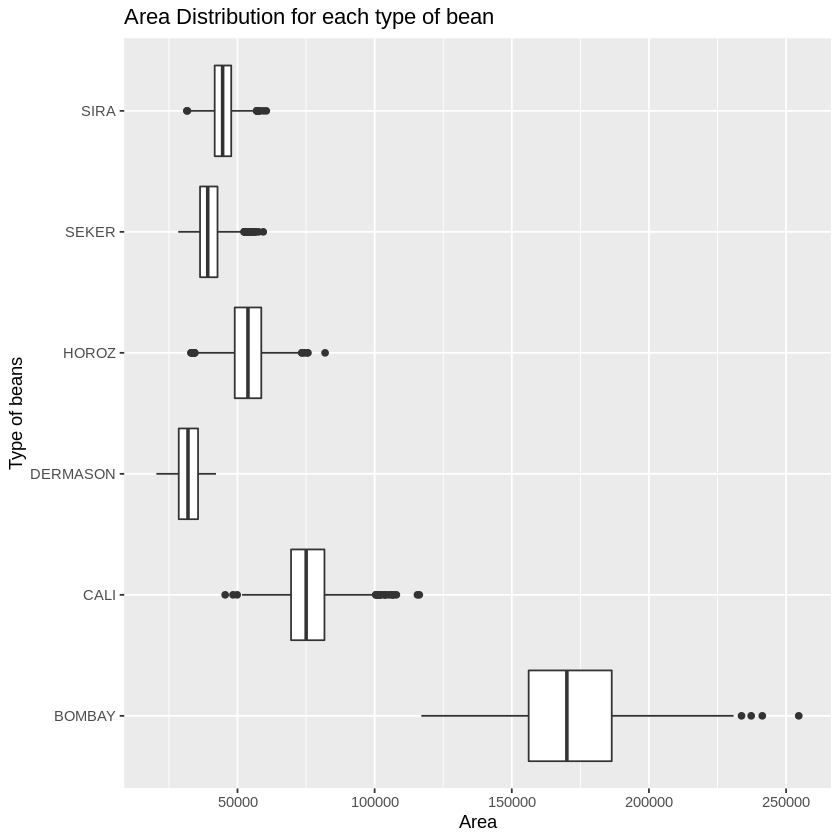

In [14]:
#Graphing area distribution for each type of bean
area_box_plot <- final_bean_data |>
                ggplot(aes(x = Class, y = Area))+
                geom_boxplot()+
                xlab("Type of beans")+
                ylab("Area")+
                ggtitle("Area Distribution for each type of bean")+
                coord_flip()
area_box_plot

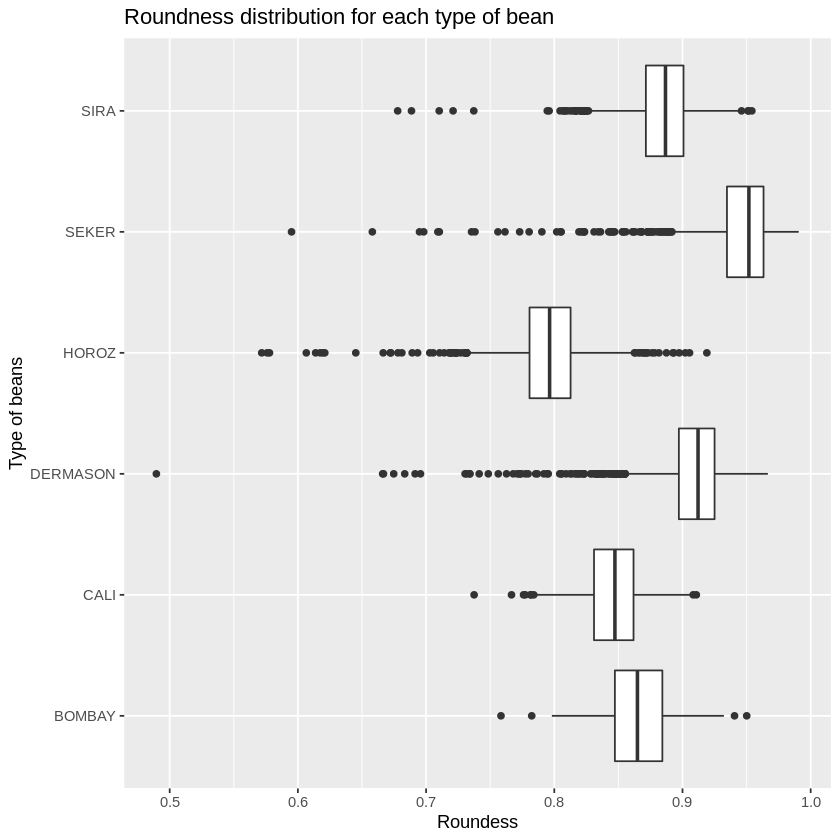

In [15]:
#Graphing box plot showing roundness distribution for each type of box plot
roundness_box_plot <- final_bean_data |>
                ggplot(aes(x = Class, y = roundness))+
                geom_boxplot()+
                xlab("Type of beans")+
                ylab("Roundess")+
                ggtitle("Roundness distribution for each type of bean")+
                coord_flip()
roundness_box_plot

# Methods
1. Data cleaning
- We will load the raw data set into R and clean it. 

2. Visualize Data
- Next, we will create visualizations such as scatterplots to identify any trends or potential outliers in the data.

3. Select Variables
- We will then select two variables: roundness and area as they are the most relevant variables for predicting the type of bean based on the physical dimensions (height and weight). 

4. Model the Data
- We will create a k-nearest neighbors (KNN) classification model using roundness and area as predictors. First, we will split the data into a training set and a testing set. Next, we will perform cross-validation by fitting the KNN model with different values of k on the training set. The testing set (has untrained data) will be used to evaluate the generalizability of the model and avoid bias. By using unseen data, we can assess the model's ability to classify new observations accurately. Finally, the testing data will be used to assess the accuracy of the KNN model for each k value, and the k value with the highest accuracy will be chosen as the optimal parameter for the model.racy as the optimal parameter for our model.

5. Visualization
- We'll make a scatterplot with colored data points for each bean type to visualize the model's performance in separating them based on the two predictors. Additionally, we'll create a confusion matrix to display the model's correct and incorrect predictions for each bean type.


# Expected outcomes and significance

What do we expect to find?
- With the help of a classification model, we expect to find a well-performing model that can predict the type of beans based on their roundness and area with high accuracy. On the visualization, we also expect to see a cluster for different types of bean in various colors.  

What impact could such findings have?
- This classification model can impact the food and agriculture industry. An automated system can be created to classifiy the type of bean based on their physical appearance. This is espcially useful when food and agriculture companies collect different types of beans together, dry them, and want to package them based on different types. The model we built can help to streamline the service, gain quality control and reduce the time for people to manually separate the beans. 

What future questions could this lead to?
- Can other variables such as major axis length or the perimeter be good predictors of the type? And are they better predictors than roundness and area?
- Can the classification model be used for different types of crops such as rice? 

# Building the Classification Model

In [16]:
set.seed(2022) # DO NOT REMOVE

bean_report_recipe <- recipe(Class ~ ., data = final_bean_data) |>
    step_scale(all_predictors()) |>
    step_center(all_predictors())
bean_report_recipe

knn_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |>
  set_engine("kknn") |>
  set_mode("classification")

bean_vfold <- vfold_cv(final_bean_data, v = 10, strata = Class)
gridvals <- tibble(neighbors = seq(1,40,by=1))

knn_results <- workflow() |>
  add_recipe(bean_report_recipe) |>
  add_model(knn_spec) |>
  tune_grid(resamples = bean_vfold, grid = gridvals) |>
  collect_metrics() |>
  filter(.metric == "accuracy")

Recipe

Inputs:

      role #variables
   outcome          1
 predictor          2

Operations:

Scaling for all_predictors()
Centering for all_predictors()

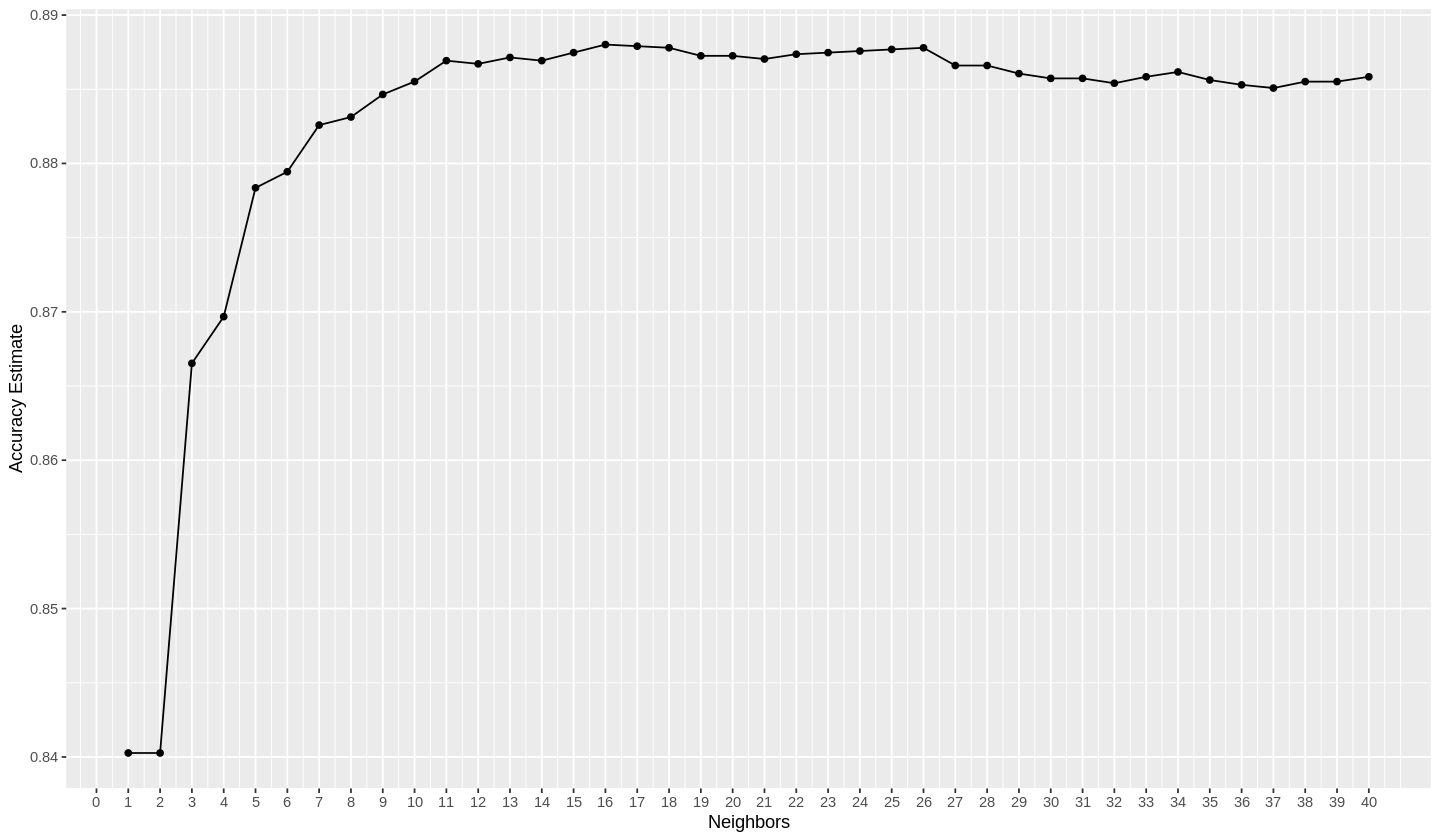

In [17]:
options(repr.plot.width = 12, repr.plot.height = 7)

# Plot k values against their respective accuracies and choose optimal k value
cross_val_plot <- knn_results |> 
    ggplot(aes(x = neighbors, y = mean)) +
    geom_point() +
    geom_line() +
    labs(x = "Neighbors", y = "Accuracy Estimate") +
    scale_x_continuous(breaks = seq(0,40, by = 1))
cross_val_plot

From the graph above we can see that with such a large dataset like the bean dataset, large number of neighbour is required to predict the data accurately. However, running cross validation for such a large dataset and large number of neighbors take a lot of time, and money, so we decided only estimate accuracies of different number of neighbors up until 45 neighbors. And it is clear that after 27 neighbours, the accuracies of different number of neighbors decreases, and the accuracies keeps decreasing until 40 neighbors, so we suspect that it will still decrease into 50 and 100 neighbors. From the graph we can see that the highest accuracies is around 25-27 neighbours. And we see that around 25 neighbors is good since the 26 neighbours, and 24 neighbours, the accuracies aren't that much different from the 25 neighbours

In [18]:
knn_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 25) |>
  set_engine("kknn") |>
  set_mode("classification")

bean_fit <- workflow() |>
  add_recipe(bean_report_recipe) |>
  add_model(knn_best_spec) |>
  fit(data = final_bean_data)
  
##(8)##
# Get the prediction column
bean_predictions <- predict(bean_fit, bean_test) |> 
    bind_cols(bean_test)

# Compare the accuracy of predictions to the true values in the test set
bean_acc <- bean_predictions |> 
    metrics(truth = Class, estimate = .pred_class) |> 
    select(.metric, .estimate) |> 
    head(1)

# Compare the predictions to the true values in a confusion matrix
bean_cm <- bean_predictions |> 
    conf_mat(truth = Class, estimate = .pred_class)
bean_acc
bean_cm

.metric,.estimate
<chr>,<dbl>
accuracy,0.8793103


          Truth
Prediction BOMBAY CALI DERMASON HOROZ SEKER SIRA
  BOMBAY      141    0        0     0     0    0
  CALI          1  379        0     6     0    2
  DERMASON      0    0      781     3    71   72
  HOROZ         0   19        8   453     7   15
  SEKER         0    0       29     1   395   18
  SIRA          0   10       61    18    30  554

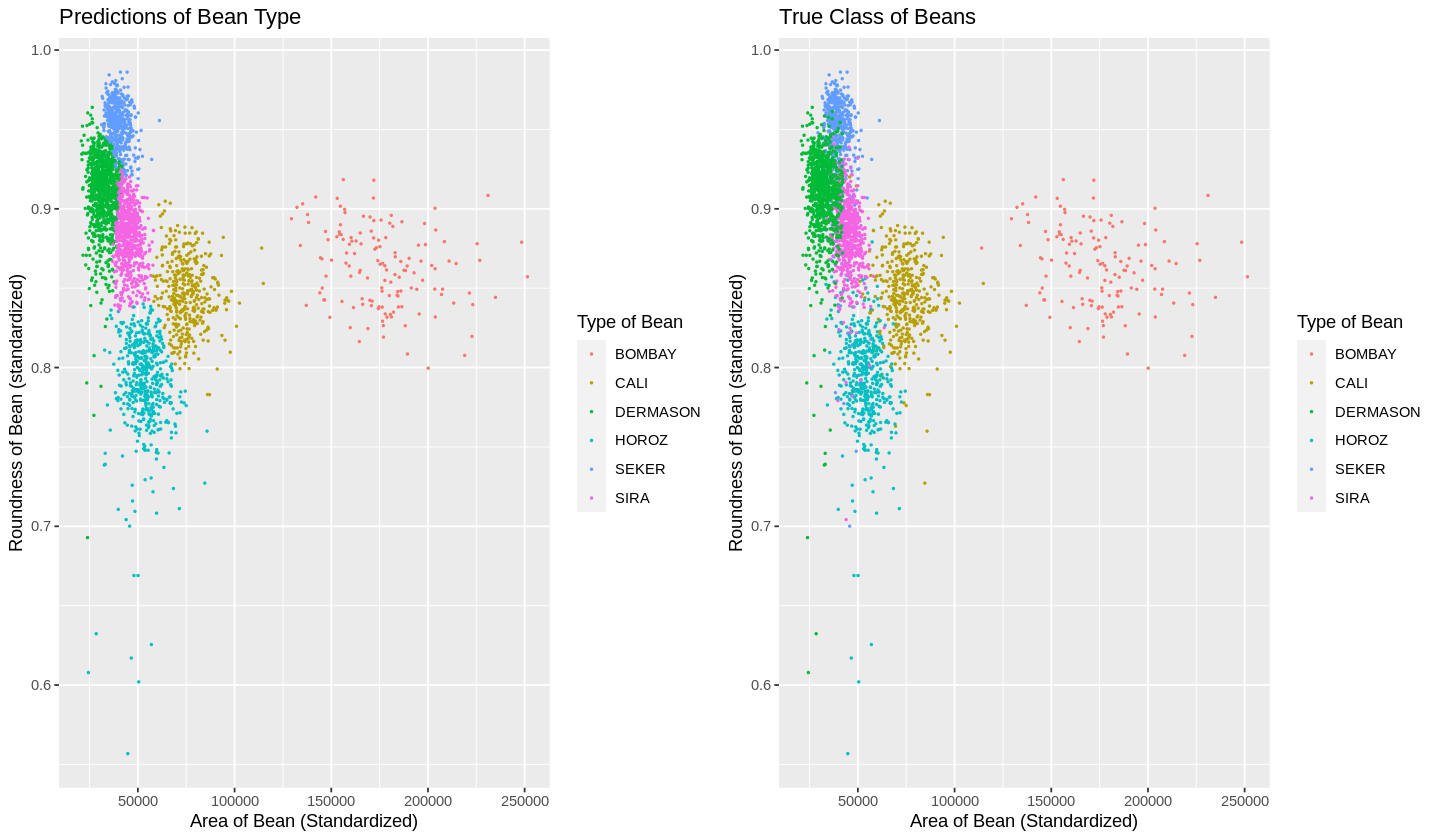

In [19]:
#visual comparison of true class vs predicted class
library(ggplot2)
library(cowplot)

bean_predictions_plot <- bean_predictions |>
    ggplot(aes(x = Area, y = roundness, color = .pred_class)) +
    geom_point(size = 0.3) +
    labs(x = "Area of Bean (Standardized)", y = "Roundness of Bean (standardized)", color = "Type of Bean") +
    ggtitle("Predictions of Bean Type")

bean_trueclass_plot <- bean_predictions |>
    ggplot(aes(x = Area, y = roundness, color = Class)) +
    geom_point(size = 0.3) +
    labs(x = "Area of Bean (Standardized)", y = "Roundness of Bean (standardized)", color = "Type of Bean") +
    ggtitle("True Class of Beans")

plot_grid(bean_predictions_plot, bean_trueclass_plot, ncol = 2)

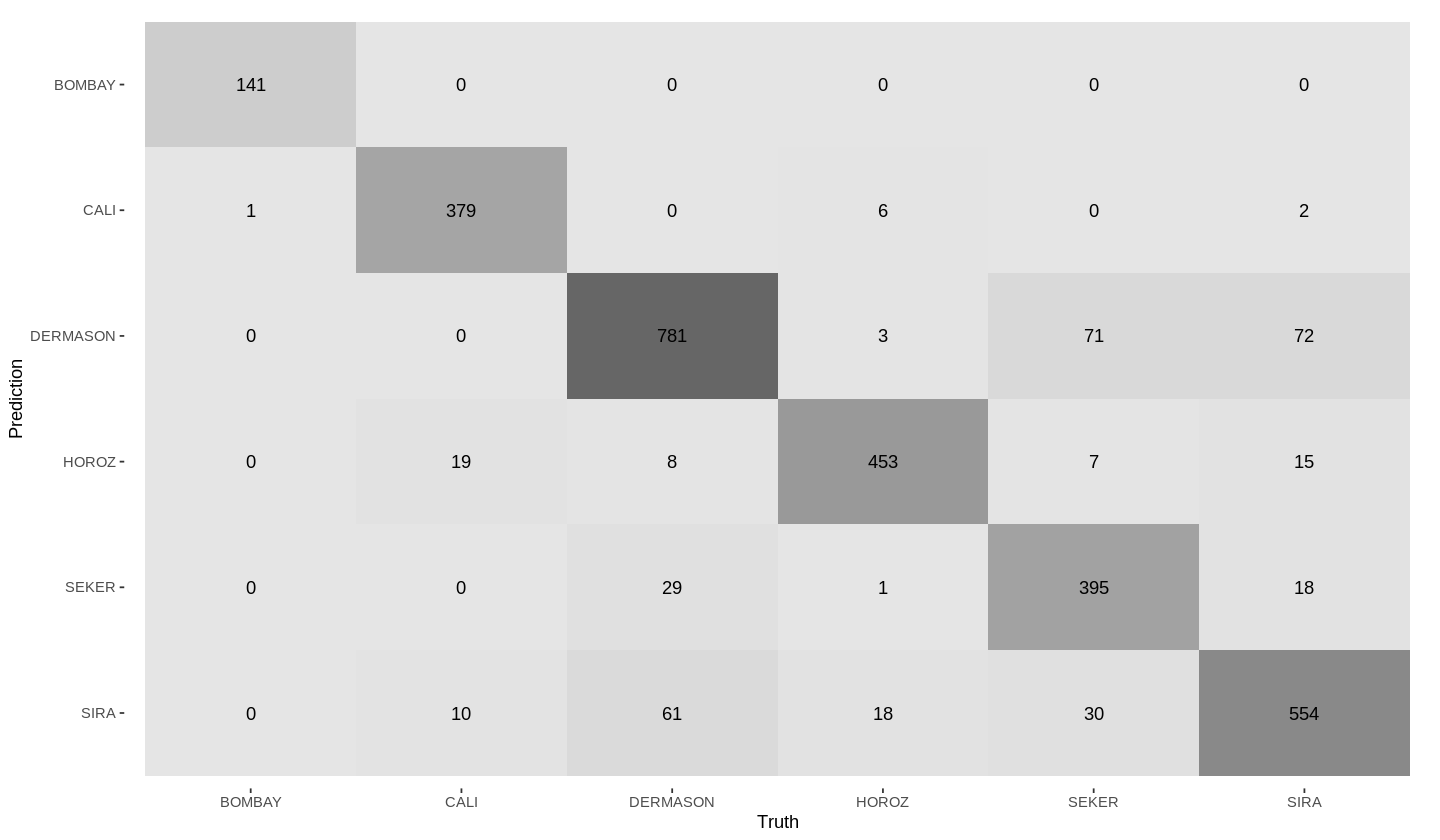

In [40]:
conf_mat_plot <- autoplot(bean_cm, type = "heatmap",color = class)
conf_mat_plot

In [43]:
conf_mat_df <- data.frame(Prediction = c("BOMBAY","CALI","DERMASON","HOROZ", "SEKER", "SIRA"),
                          BOMBAY = c(141,1,0,0,0,0),
                          CALI = c(0,379,0,19,0,10),
                          DERMASON = c(0,0,781,8,29,61),
                          HOROZ = c(0,6,3,453,1,18),
                          SEKER = c(0,0,71,7,395,30),
                          SIRA = c(0,2,72,15,18,554))
conf_mat_df

Prediction,BOMBAY,CALI,DERMASON,HOROZ,SEKER,SIRA
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
BOMBAY,141,0,0,0,0,0
CALI,1,379,0,6,0,2
DERMASON,0,0,781,3,71,72
HOROZ,0,19,8,453,7,15
SEKER,0,0,29,1,395,18
SIRA,0,10,61,18,30,554


In [45]:
conf_mat_longer <- conf_mat_df |>
            pivot_longer(cols= BOMBAY:SIRA,
                         names_to = "Truth",
                         values_to = "num_predict")
conf_mat_longer

Prediction,Truth,num_predict
<chr>,<chr>,<dbl>
BOMBAY,BOMBAY,141
BOMBAY,CALI,0
BOMBAY,DERMASON,0
BOMBAY,HOROZ,0
BOMBAY,SEKER,0
BOMBAY,SIRA,0
CALI,BOMBAY,1
CALI,CALI,379
⋮,⋮,⋮


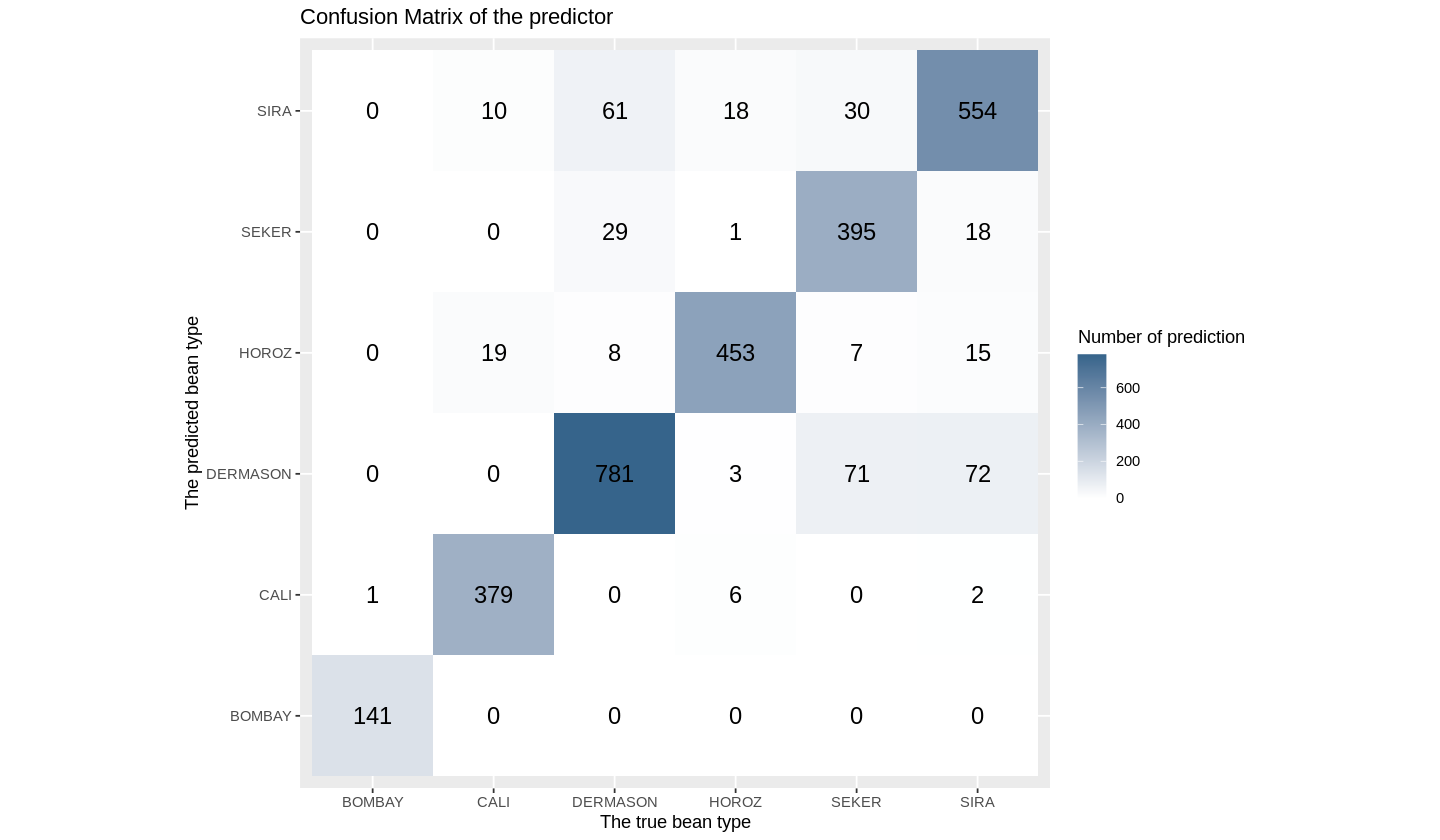

In [68]:
conf_mat_plot <- conf_mat_longer |>
                ggplot(aes(x = Truth, y = Prediction, fill = num_predict)) +
                geom_tile()+
                scale_fill_gradient2(low= "white", high = "steelblue4")+
                guides(fill = guide_colourbar(title = "Number of prediction"))+
                geom_text(aes(label = num_predict), color = "black", size = 5)+
                ggtitle("Confusion Matrix of the predictor")+
                labs(x="The true bean type",
                     y="The predicted bean type")+
                coord_fixed()
conf_mat_plot

###### References:
- Krzywinski, Martin, and Naomi Altman. "Visualizing samples with box plots: use box plots to illustrate the spread and differences of samples." Nature Methods, vol. 11, no. 2, Feb. 2014, pp. 119+. Gale OneFile: Health and Medicine, link.gale.com/apps/doc/A361242515/HRCA?u=ubcolumbia&sid=bookmark-HRCA&xid=0db0fe06. Accessed 11 Mar. 2023.

- Koklu, M., & Ozkan, I. A. (2020). Multiclass classification of dry beans using computer vision and machine learning techniques. Computers and Electronics in Agriculture, 174, 105507. https://doi.org/10.1016/j.compag.2020.105507